# Flight Arrival Time Prediction


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, skew, kurtosis
import random
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean, mode, median
import warnings
import time as tm
import math
warnings.filterwarnings('ignore')

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF'
           ,'#67E568','#257F27','#08420D','#FFF000','#FFB62B','#E56124','#E53E30','#7F2353','#F911FF','#9F8CA6']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7)
sns.set_style('darkgrid')

np.random.seed(sum(map(ord, "aesthetics")))

# Data Preparation


In [3]:
#seed is set to 0 to ensure consistency throughout the notebook
np.random.seed(0)

#read the dataset
data = pd.read_csv('Input/DelayedFlights.csv',index_col=None)


In [4]:
# drop the index column
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1,inplace=True)

# drop cancelled flight records
data = data[data.Diverted != 1]

# drop diverted flight records
data = data[data.Cancelled != 1]

# drop any records which does not have arraival delay value
data.dropna(subset=['ArrDelay'],inplace=True)

data.head(10)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
5,2008,1,3,4,1937.0,1830,2037.0,1940,WN,509,...,3.0,7.0,0,N,0,10.0,0.0,0.0,0.0,47.0
6,2008,1,3,4,706.0,700,916.0,915,WN,100,...,5.0,19.0,0,N,0,NaN,NaN,NaN,NaN,NaN
7,2008,1,3,4,1644.0,1510,1845.0,1725,WN,1333,...,6.0,8.0,0,N,0,8.0,0.0,0.0,0.0,72.0
8,2008,1,3,4,1029.0,1020,1021.0,1010,WN,2272,...,6.0,9.0,0,N,0,NaN,NaN,NaN,NaN,NaN
9,2008,1,3,4,1452.0,1425,1640.0,1625,WN,675,...,7.0,8.0,0,N,0,3.0,0.0,0.0,0.0,12.0


From all available features in the dataset, only relevant features will be included. Following columns are Cause of Delay and cannot be included in the training dataset to prevent overfitting:

- CarrierDelay(Carrier Delay, in Minutes Analysis)
- WeatherDelay(Weather Delay, in Minutes  Analysis)
- NASDelay(National Air System Delay, in Minutes Analysis)
- SecurityDelay(Security Delay, in Minutes Analysis)
- LateAircraftDelay(Late Aircraft Delay, in Minutes Analysis)


In [5]:
response = 'ArrDelay'
predictors = ['Month', 'DayofMonth', 'DayOfWeek', 'CRSElapsedTime','CRSArrTime' ,'CRSDepTime','DepDelay','Distance','UniqueCarrier', 'Origin', 'Dest']

data = data[[response]+predictors]

In [6]:
data.head(10)

,ArrDelay,Month,DayofMonth,DayOfWeek,CRSElapsedTime,CRSArrTime,CRSDepTime,DepDelay,Distance,UniqueCarrier,Origin,Dest
0,-14.0,1,3,4,150.0,2225,1955,8.0,810,WN,IAD,TPA
1,2.0,1,3,4,145.0,1000,735,19.0,810,WN,IAD,TPA
2,14.0,1,3,4,90.0,750,620,8.0,515,WN,IND,BWI
3,34.0,1,3,4,90.0,1925,1755,34.0,515,WN,IND,BWI
4,11.0,1,3,4,115.0,2110,1915,25.0,688,WN,IND,JAX
5,57.0,1,3,4,250.0,1940,1830,67.0,1591,WN,IND,LAS
6,1.0,1,3,4,135.0,915,700,6.0,828,WN,IND,MCO
7,80.0,1,3,4,135.0,1725,1510,94.0,828,WN,IND,MCO
8,11.0,1,3,4,50.0,1010,1020,9.0,162,WN,IND,MDW
9,15.0,1,3,4,240.0,1625,1425,27.0,1489,WN,IND,PHX


In [7]:
print('Maximum value of arrival delay: {0} minutes'.format(data['ArrDelay'].max()))
print('Minimum value of arrival delay: {0} minutes'.format(data['ArrDelay'].min()))

Maximum value of arrival delay: 2461.0 minutes
Minimum value of arrival delay: -109.0 minutes


In [8]:
print('Total number of not null values for :\n\n{0} '.format(data.count()))

Total number of not null values for :

ArrDelay          1928371
Month             1928371
DayofMonth        1928371
DayOfWeek         1928371
CRSElapsedTime    1928371
CRSArrTime        1928371
CRSDepTime        1928371
DepDelay          1928371
Distance          1928371
UniqueCarrier     1928371
Origin            1928371
Dest              1928371
dtype: int64 


# Exploratory Data Analysis (EDA)

In the following section EDA will is conducted to find Pearson correlation between selected predictors and response variable.


# Correlation Matrix

Correlation matrix is used to find linear relationship between predictors and response variable.


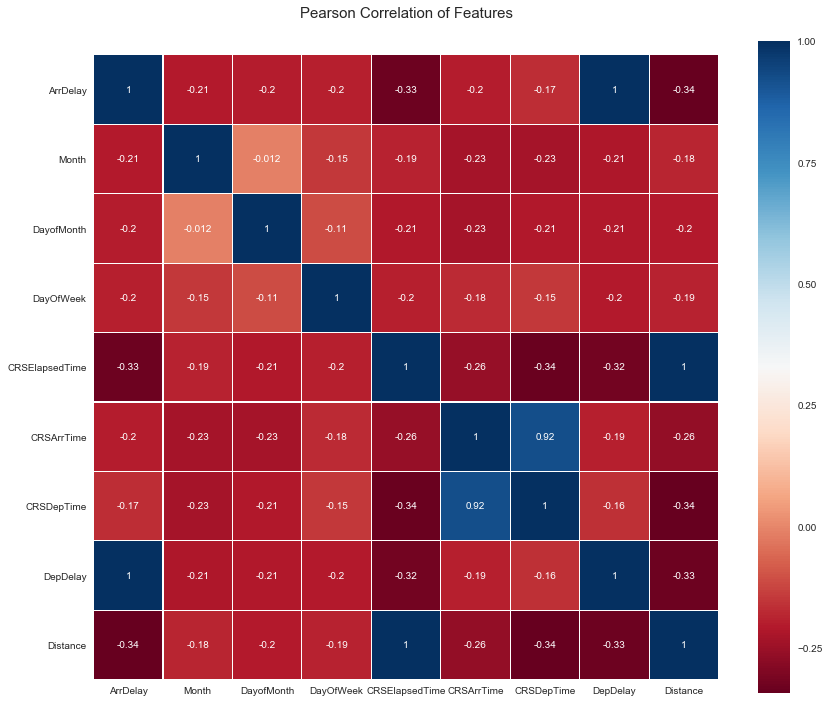

In [9]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
corr01 = data.corr()
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(corr01.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

The Pearson matrix shows the correlation between two predictors CRSElapsedTime and Distance is one. This means most probability only one of these predictors is needed for training the algorithsm since the represent same information. The impact of keeping both predictors and dropping one of them has been tested and 

In [10]:
data.drop('CRSElapsedTime', axis=1, inplace=True)


 mu = 42.20 and sigma = 56.78



Text(0.5,1,'Arrival Delay Distribution')

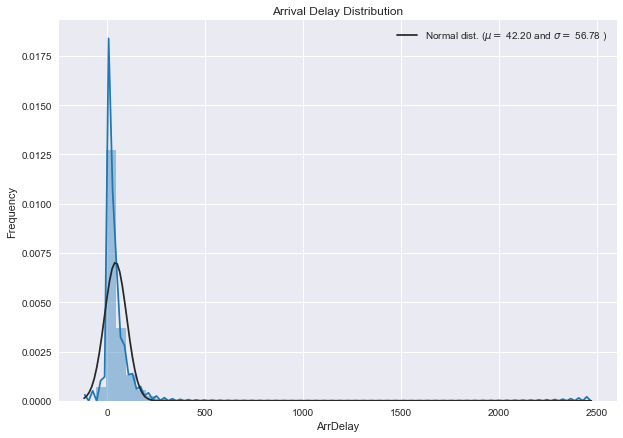

In [11]:
sns.distplot(data['ArrDelay'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit( data['ArrDelay'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Arrival Delay Distribution')

Additional information such as skewness, kurtosis, QQ plot and Jarque Berra test were given below to verify the visual interpretation. The data is positively skewed and has excess kurtosis of 3.0. 

In [12]:
skew(data['ArrDelay'])


3.9487773027158917

In [13]:
kurtosis(data['ArrDelay'], fisher=False)

42.27500306408947

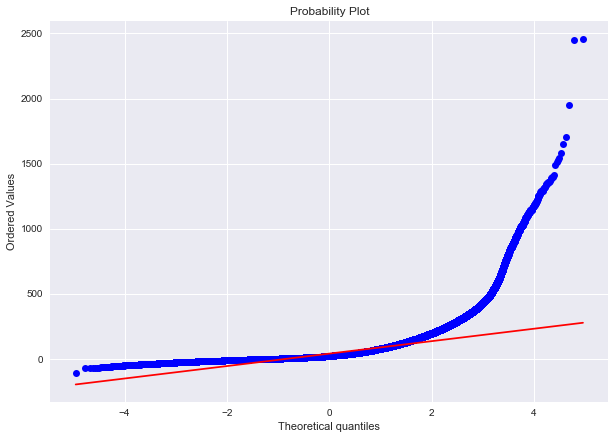

In [14]:
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['ArrDelay'], plot=plt)
plt.show()

QQplot shows that the data is not following a straight line which indicate a non normality.

In [15]:
#to count missing values on each variable
data.dropna(inplace=True)
data.isnull().sum()

ArrDelay         0
Month            0
DayofMonth       0
DayOfWeek        0
CRSArrTime       0
CRSDepTime       0
DepDelay         0
Distance         0
UniqueCarrier    0
Origin           0
Dest             0
dtype: int64

In [16]:
data_dum = pd.get_dummies(data, drop_first=True)

In [17]:
data_dum.head()
data.count()

ArrDelay         1928371
Month            1928371
DayofMonth       1928371
DayOfWeek        1928371
CRSArrTime       1928371
CRSDepTime       1928371
DepDelay         1928371
Distance         1928371
UniqueCarrier    1928371
Origin           1928371
Dest             1928371
dtype: int64

# Train-Test Split

Since the dataset is very large we split it into 10%-90% train set - test set for model evaluation.
The result of 10% train set is evaluated initially to ensure it can produce desirable outcome.


In [18]:
# split data intro training and test datasets
from sklearn.model_selection import train_test_split
Y = data['ArrDelay']

# split the dataset to train and test
X_train, X_test = train_test_split(data_dum, test_size=0.05,train_size=0.05, random_state=0)
X_train_full = X_train.copy()
Y_train = X_train['ArrDelay']
X_test_full = X_test.copy()
Y_test = X_test['ArrDelay']
X_train.drop('ArrDelay',axis=1,inplace=True)
X_test.drop('ArrDelay',axis=1,inplace=True)

 

In [19]:
len(Y_train)

96418

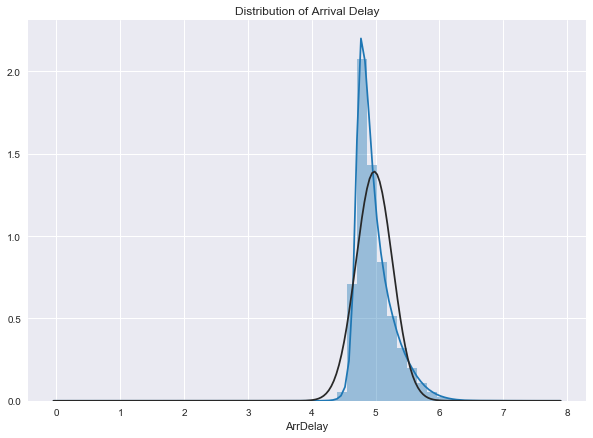

In [20]:
# adding constant to the response values and transforming the arrival delay time to log arrival delay time
Y_train_log = np.log(Y_train+110)
Y_test_log = np.log(Y_test+110)

# plotting log log arrival delay distribution to see impact of log transformation on the skewed data and its distribution
sns.distplot(np.log(Y+110), fit=norm);
plt.title('Distribution of Arrival Delay')
plt.show()

In [21]:
skew(np.log(Y+110))

1.3941726420389673

In [22]:
kurtosis(np.log(Y+110), fisher=False)


5.789904254574883

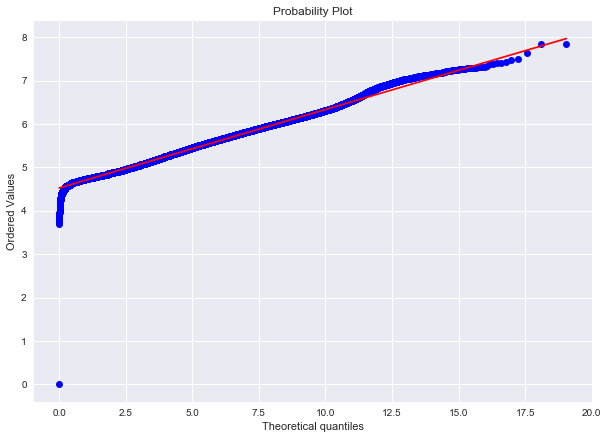

In [23]:
#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(np.log(Y+110), plot=plt,dist=stats.gamma, sparams=(2.5,))
plt.show()

# Model Development

Import required libraries for Ridge, Lasso and Tree regression models in addition to the evalution libraries.

In [24]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
import statsmodels.formula.api as smf
import statsmodels.api as sm


# OLS Regression

We use OLS as the base model, which clearly shows a linear relationship between Departure Delay and Arrival Delay.

In [25]:
%%time

t0 = tm.time()
np.random.seed(0)

# including dummy variable had negative impact on the error term and overfitted model,
# so based on the performance it is been decided to just select non-categorical variable for OLS regression
##ols = LinearRegression()
##ols.fit(X_train, Y_train)

ols = smf.ols(formula = 'ArrDelay ~ Month+DayofMonth+DayOfWeek+CRSDepTime+DepDelay', data = X_train_full).fit()
t_ols = tm.time() - t0

Wall time: 86 ms


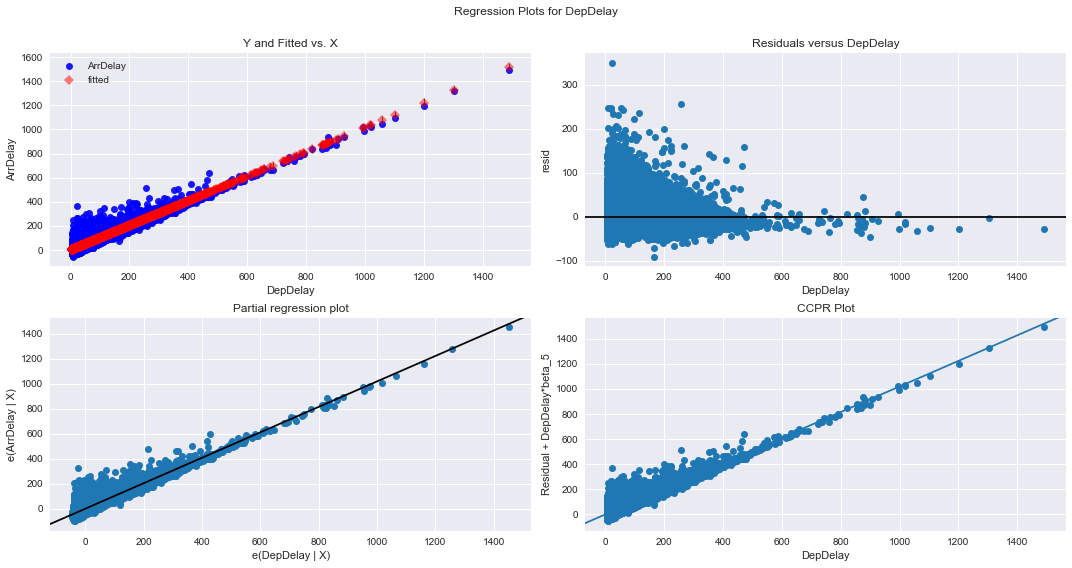

In [26]:
fig = plt.figure(figsize=(15,8))
fig= sm.graphics.plot_regress_exog(ols,"DepDelay",fig=fig)

# Ridge Regression

Ridge regression function with built-in cross-validation (RidgeCV) is used to apply 10-fold cross validation and while trying different different penalty weight values (called alphas by the package). For Ridge regression we also need to standardize the data as one the assuptions of the redige regression

In [27]:
%%time

np.random.seed(0)
t0 = tm.time()
alphas = [1e-3, 1e-2, 1e-1, 1]

ridge = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', RidgeCV(alphas=alphas, cv=10)),
))

ridge.fit(X_train, Y_train)
t_ridge = tm.time() - t0



Wall time: 2min 19s


# Lasso Regression

Lasso regression function with built-in cross-validation (LassoCV) is used to apply 10-fold cross validation and while trying different different penalty weight values (called alphas by the package). 
Since the number of features are high we also test Lasso regression which has the power of removing unimportant features by setting zero weight for them.

In [28]:
%%time

np.random.seed(0)
t0 = tm.time()
alphas = [1e-3, 1e-2, 1e-1, 1]

lasso = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', LassoCV(alphas=alphas,cv=10)),
))

lasso.fit(X_train, Y_train)

# lasso 
reg = lasso._final_estimator
print('Nubmer of predictors with non-zero coefficients : ', np.sum(reg.coef_!= 0.0))
print('Nubmer of predictors with zero coefficients : ', np.sum(reg.coef_== 0.0))
 
t_lasso = tm.time() - t0


Nubmer of predictors with non-zero coefficients :  537
Nubmer of predictors with zero coefficients :  92
Wall time: 43.1 s


# Regression Tree

In [29]:
%%time

np.random.seed(0)
t0 = tm.time()

model = DecisionTreeRegressor(min_samples_leaf=5)

tuning_parameters = {
    'min_samples_leaf': [5,10,15],
    'max_depth': np.arange(5,10),
}

# to improve the running time of the regression tree optimization and training 
# maximum number of cores for parallel processing is used (n_jobs=-1)
tree = RandomizedSearchCV(model, tuning_parameters, n_iter=15, cv=10, return_train_score=False,n_jobs=-1)
tree.fit(X_train, Y_train)

print('Best parameters:', tree.best_params_)

t_tree = tm.time() - t0


Best parameters: {'min_samples_leaf': 5, 'max_depth': 7}
Wall time: 5min 12s


# Evaluation of the Result

After tunning the parameters for the models and finding the optimal parameters, a 10-fold cross validation will be run for evaluation and finding the best performing model.


In [30]:
#Split test set in 10 folds
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)


In [31]:
columns=['Test NLL','Test RMSE', 'Test MAE', 'Test R2', 'Training Time(Seconds)']
rows=['ols','Ridge','Lasso','Tree']
time=[t_ols,t_ridge,t_lasso,t_tree]
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ols,ridge,lasso,tree]

for i, method in enumerate(methods):

    #initalize evaulation metrix

    NLL = []
    RMSE = []
    MAE = []
    R2  = []
    
    for train_index, test_index in kf.split(X_test):
        if i==0:
            ols = smf.ols(formula = 'ArrDelay ~ Month+DayofMonth+DayOfWeek+CRSDepTime+DepDelay+Distance', data = X_test_full.iloc[train_index]).fit()
            y_pred = ols.predict(X_test.iloc[test_index])

        else:
            method.fit(X_test.iloc[train_index], Y_test.iloc[train_index])
            y_pred = method.predict(X_test.iloc[test_index])  

        NLL = np.append(NLL,1/2*(np.log(2*(math.pi)*y_pred.var()))+(np.sum(Y_test.iloc[test_index]-y_pred.mean()))**2/(2*y_pred.var()**2))
        RMSE = np.append(RMSE,np.sqrt(mean_squared_error(Y_test.iloc[test_index],y_pred)))
        MAE = np.append(MAE,mean_absolute_error(Y_test.iloc[test_index],y_pred))
        R2  = np.append(R2,r2_score(Y_test.iloc[test_index], y_pred))
                        
    # calculate Negative Log Likelihood (NLL)
    results.iloc[i,0] = mean(NLL)

    # calculate Root Mean Squared Error (RMSE)
    results.iloc[i,1] = mean(RMSE)

    # calculate Mean Absolute Error (MAE)
    results.iloc[i,2] = mean(MAE)

    # calculate R2 score
    results.iloc[i,3] = mean(R2)

    results.iloc[i,4] = time[i]

results.round(3)

,Test NLL,Test RMSE,Test MAE,Test R2,Training Time(Seconds)
ols,5.076,17.033,11.240,0.910,0.086
Ridge,5.058,16.813,11.091,0.913,139.509
Lasso,5.058,16.806,11.080,0.913,43.132
Tree,5.100,17.207,11.328,0.909,312.268
